## Neigbourhoods functions

### Librairies

In [1]:
from random import shuffle, randint
import import_ipynb
from Grid import *

### VHSD

#### End Move

In [2]:
def end_move(c, k) :
    """
    Applies an end move to residue k, where k must be first (0) or last residue (n-1).

    Args :
        c (list of tuples) : current conformation
        k (int) : index of the residue to move (0 or n-1)
        
    Returns :
        tuple : (bool, new_conformation)
            bool : True if the move was successful, False otherwise
            new_conformation : the new conformation after the move (or the original if no move was possible)    
    """

    cp = c.copy()

    if k == 0:
        neighbour_residue = c[1]  # Residue 1
    else:  # k == n-1
        neighbour_residue = c[-2]  # Residue n-2

    # Possible directions in a 2D lattice:
    x_nr = neighbour_residue[0]
    y_nr = neighbour_residue[1]
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)] 
    shuffle(directions) # We shuffle to get a random position and not necessary the first one

    for x, y in directions:
        # We test all the neighbour position of neighbour_residue and return the first one which is empty
        new_x = x_nr + x
        new_y = y_nr + y
        new_k = (new_x, new_y)

        if  (new_k not in c) :
            if k == 0 :
                cp[0] = new_k
            else :
                cp[-1] = new_k
            return (True, cp)

    return (False, cp)  # No move possible

#### Corner Move

In [3]:
def corner_move(c, k):
    """
    Applies a corner move to residue k, where k must be between 1 and n-2.

    Args :
        c (list of tuples) : current conformation
        k (int) : index of the residue to move (0 or n-1)
        
    Returns :
        tuple : (bool, new_conformation)
            bool : True if the move was successful, False otherwise
            new_conformation : the new conformation after the move (or the original if no move was possible)
    """
    cp =  c.copy()

    # We create variable containing the coordonates of k, its previous neighbours and its next one.
    coord, coord_prev, coord_next = cp[k], cp[k-1], cp[k+1]
    x, y = coord[0], coord[1]
    x_prev, y_prev = coord_prev[0], coord_prev[1]
    x_next, y_next = coord_next[0], coord_next[1]

    if x_prev != x_next and y_prev != y_next : 
        # The condition above checks if k and its neighbours form a corner.
        if x_prev == x and ((x_next, y_prev) not in c) :
            cp[k] = (x_next, y_prev)
            return (True, cp)
        elif ((x_prev, y_next) not in c) :
            cp[k] = (x_prev, y_next)
            return (True, cp)
        
    return (False, cp)

#### Crankshaft Move

In [4]:
def crankshaft_move(c, k):
    """
    Applies a crankshaft move to residue k, where k must be between 1 and n-3.
    We consider k as the first corner of the U-shaped segment.

    Args:
        c (list of tuples): Current conformation as a list of (x, y) coordinates
        k (int): Index of the residue to move (must be between 1 and n-3)

    Returns:
        tuple: (bool, new_conformation)
            bool: True if the move was successful, False otherwise
            new_conformation: The new conformation after the move (or the original if no move was possible)
    """

    cp = c.copy()

    # Get coordinates of the four residues involved in the crankshaft move
    x_prev, y_prev = cp[k-1]   # Previous residue (first corner of U)
    x, y = cp[k]              # Current residue (second corner of U)
    x_next, y_next = cp[k+1]  # Next residue (third corner of U)
    x_next2, y_next2 = cp[k+2] # Residue after next (fourth corner of U)

    # Check for horizontal U-shape (residues k-1 and k+2 have same x-coordinate)
    if x_prev == x_next2 and x == x_next:
        # Case 1: U opens to the right - rotate 180° to the left
        if x == x_prev + 1 and ((x - 2, y) not in c) and ((x_next - 2, y_next) not in c):
            cp[k] = (x - 2, y)          # Move current residue left by 2 units
            cp[k+1] = (x_next - 2, y_next)  # Move next residue left by 2 units
            return (True, cp)

        # Case 2: U opens to the left - rotate 180° to the right
        elif x == x_prev - 1 and ((x + 2, y) not in c) and ((x_next + 2, y_next) not in c):
            cp[k] = (x + 2, y)          # Move current residue right by 2 units
            cp[k+1] = (x_next + 2, y_next)  # Move next residue right by 2 units
            return (True, cp)

    # Check for vertical U-shape (residues k-1 and k+2 have same y-coordinate)
    elif y_prev == y_next2 and y == y_next:
        # Case 3: U opens downward - rotate 180° upward
        if y == y_prev + 1 and ((x, y - 2) not in c) and ((x_next, y_next - 2) not in c):
            cp[k] = (x, y - 2)          # Move current residue down by 2 units
            cp[k+1] = (x_next, y_next - 2)  # Move next residue down by 2 units
            return (True, cp)

        # Case 4: U opens upward - rotate 180° downward
        elif y == y_prev - 1 and ((x, y + 2) not in c) and ((x_next, y_next + 2) not in c):
            cp[k] = (x, y + 2)          # Move current residue up by 2 units
            cp[k+1] = (x_next, y_next + 2)  # Move next residue up by 2 units
            return (True, cp)

    # If none of the above conditions are met, return False with original conformation
    return (False, cp)

#### Random VSHD Move

In [5]:
def M_vshd(c, k):
    """
    Applies a VSHD move (end, corner, or crankshaft) to residue k.

    Args:
        c (list of tuples): Current conformation as a list of (x, y) coordinates
        k (int): Index of the residue to move (must be between 1 and n-3)

    Returns:
        tuple: (bool, new_conformation)
            bool: True if the move was successful, False otherwise
            new_conformation: The new conformation after the move (or the original if no move was possible)
    """
    c_prime = c.copy()  # Create a copy of the conformation
    n = len(c_prime)

    # Case 1: End move (if k is the first or last residue)
    if k == 0 or k == n-1:
        end_move_possible, new_c = end_move(c_prime, k)
        if end_move_possible:
            return (True, new_c)

    # Case 2: Corner move (if k is the second-to-last residue)
    elif k == n-2:
        corner_possible, new_c = corner_move(c_prime, k)
        if corner_possible:
            return (True, new_c)

    # Case 3: For internal residues, try corner or crankshaft move
    else:
        rand = randint(1, 2)  # Randomly choose between corner and crankshaft
        corner_possible, new_c_corner = corner_move(c_prime, k)
        crankshaft_possible, new_c_crankshaft = crankshaft_move(c_prime, k)

        # Try corner move first if randomly selected
        if rand == 1 and corner_possible:
            return (True, new_c_corner)

        # Try crankshaft move if possible
        if crankshaft_possible:
            return (True, new_c_crankshaft)
        
        # If crankshaft not possible but corner is, use corner move
        if corner_possible:
            return (True, new_c_corner)

    # If no move is possible, return the unchanged conformation
    return (False, c_prime)

### Pull Move

INCOMPLET : A REVOIR

In [ ]:
def pull_move(c, k):
    """
    Applies a crankshaft pull move to residue k.
    We consider k as the first corner of the U-shaped segment.

    Args:
        c (list of tuples): Current conformation as a list of (x, y) coordinates
        k (int): Index of the residue to move (must be between 1 and n-3)

    Returns:
        tuple: (bool, new_conformation)
            bool: True if the move was successful, False otherwise
            new_conformation: The new conformation after the move (or the original if no move was possible)
    """
    c0 =c.copy()
    cp = c.copy()

    n =len(c0)

    while k != n-1 :
        xi, yi = c0[k]
        xi_prev, yi_prev = c0[k-1]
        xi_next, yi_next = c0[k+1]

        # Two candidates possibles to be adjacent to previous residue and in the corner of the current one (L)
        L1_x, L1_y = xi_prev + (yi_prev - yi), yi_prev + (xi - xi_prev)
        L2_x, L2_y = xi_prev - (yi_prev - yi), yi_prev - (xi - xi_prev)

        # And the two candidates to be in the corner (C)
        C1_x, C1_y = xi - (yi - yi_prev), yi - (xi_prev - xi)
        C2_x, C2_y = xi + (yi - yi_prev), yi + (xi_prev - xi)

        # We check if L1/2 is free and C1/2 is on the same place with next residue
        cond_L1_in_Cp = (L1_x, L1_y) not in cp
        cond_L2_in_Cp = (L2_x, L2_y) not in cp

        if cond_L1_in_Cp and (C1_x, C1_y) == (xi_next, yi_next) :
            cp[k] = (L1_x, L1_y)
            return (True, cp)
        
        elif cond_L2_in_Cp and (C2_x, C2_y) == (xi_next, yi_next) :
            cp[k] = (L2_x, L2_y)
            return (True, cp)

        elif cond_L1_in_Cp and (C1_x, C1_y) not in cp:
            cp[k] = (L1_x, L1_y)
            k += 1

        elif cond_L2_in_Cp and (C2_x, C2_y) not in cp:
            cp[k] = (L2_x, L2_y)
            k += 1

        return (False, c0)

In [ ]:
def pull_move(c, i):
    """
    Performs a pull move on a 2D self-avoiding chain.
    c: list of (x,y) tuples
    i: index of the residue to pull (1 <= i < len(c)-1)
    Returns: (success, new_c)
            - success: boolean (True if move is valid, False otherwise)
            - new_c: new conformation (if successful) or original c
    """

    n = len(c)
    xi, yi = c[i]
    xip1, yip1 = c[i+1]
    directions = [(1,0),(-1,0),(0,1),(0,-1)]

    for dx, dy in directions:
        L = (xip1+dx, yip1+dy)
        if L in c:  # must be free
            continue
        if abs(L[0]-xi) + abs(L[1]-yi) != 2:
            continue  # must be diagonally adjacent to i

        # C = adjacent to i and L
        C = (xi + (L[0]-xi)//2, yi + (L[1]-yi)//2)

        # Case 1: corner move
        if C == c[i-1]:
            cp = c.copy()
            cp[i] = L
            if len(set(cp)) == len(cp):
                return True, cp
            continue

        # Cases 2 and 3: initial displacement
        if C in c and C != c[i-1]:
            continue  # collision
        cp = c.copy()
        cp[i] = L
        cp[i-1] = C

        # Backward propagation if needed
        j = i-2
        while j >= 0:
            new_pos = c[j+1]  # position freed by j+1
            if new_pos in cp[:j] + cp[j+1:]:
                break  # collision → invalid
            cp[j] = new_pos
            j -= 1

        # Check final validity
        if len(set(cp)) == len(cp):
            return True, cp
    return False, c

Pull move result: (False, [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3), (1, 2), (0, 2), (0, 1), (0, 0)])


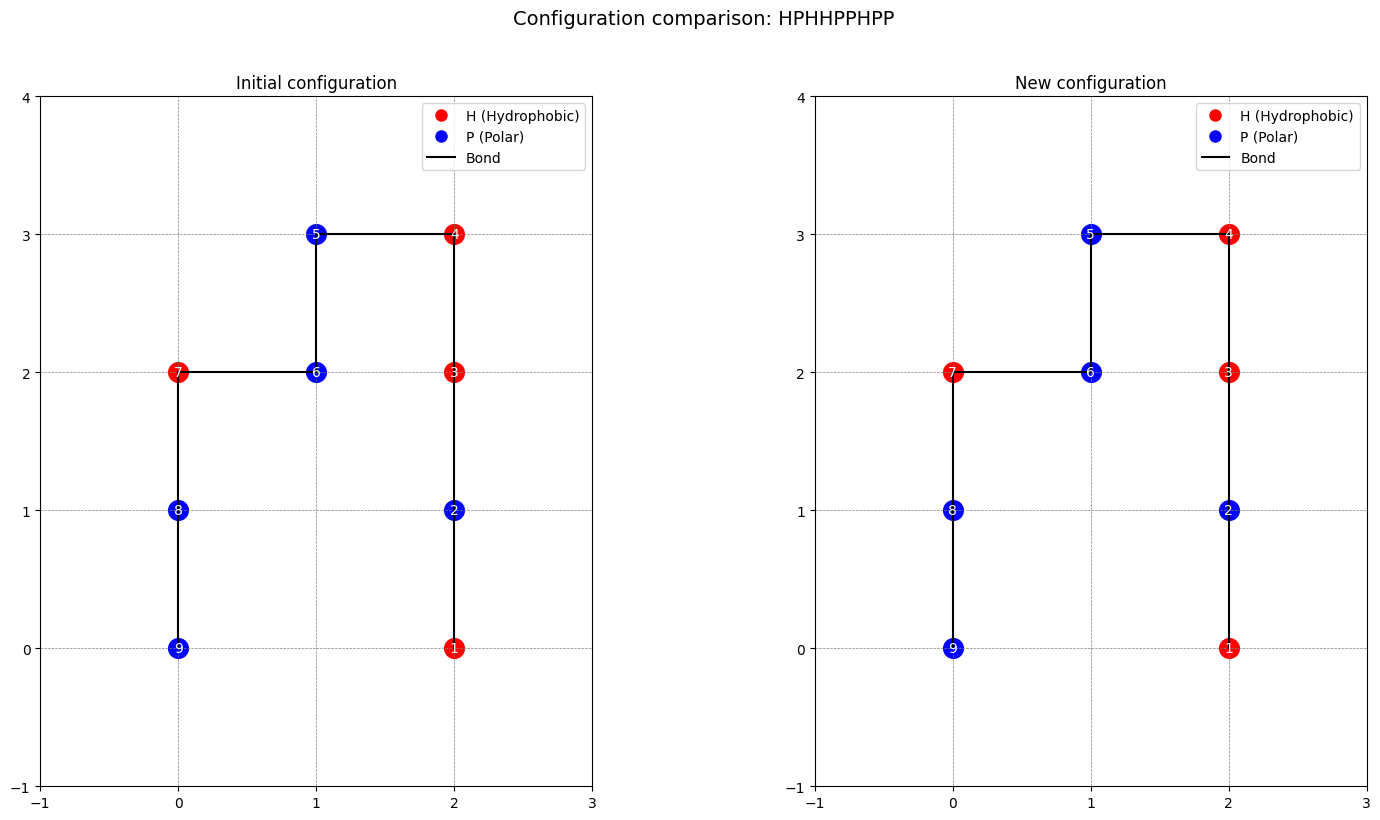

In [156]:
# Exemple
hp = "HPHHPPHPP"
c = [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 2), (2, 1), (2, 0)]
c = [(2, 0), (2, 1), (2, 2), (2, 3), (1, 3), (1, 2), (0, 2), (0, 1),(0, 0) ]
cp = pull_move(c, 2)
print("Pull move result:", cp)
plot_molecules_side_by_side(c, cp[1], hp)